In [1]:
!pip install gdown  # Ensure gdown is installed

In [2]:
import gdown

# Replace FILE_ID with your actual file ID
file_id = "1mH1dnfo01foIrhbT5VTiv5wyR_7QStUO"
output_file = "Pistols_Datasets.zip"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1mH1dnfo01foIrhbT5VTiv5wyR_7QStUO
To: /content/Pistols_Datasets.zip
100%|██████████| 21.2M/21.2M [00:00<00:00, 84.3MB/s]


'Pistols_Datasets.zip'

In [3]:
import zipfile
z = zipfile.ZipFile('/content/Pistols_Datasets.zip')
z.extractall()

## **Importing libraries**

In [4]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import cv2
import os

## **Removing annotation file with size zero**

In [5]:

annotation_dirs = ["Pistols_Datasets/train/labels"]
images_dirs = ["Pistols_Datasets/train/images"]

print(f'Before : {len(os.listdir(annotation_dirs[0]))}')

for annotation_dir, images_dir in zip(annotation_dirs, images_dirs):
    annotations = os.listdir(annotation_dir)
    images = set(os.listdir(images_dir))  # Use a set for faster lookup

    for annotation in annotations:
        annotation_file = os.path.join(annotation_dir, annotation)
        image_file_name = annotation[:-4] + '.jpg'

        # Delete annotation file if the corresponding image is missing
        if image_file_name not in images:
            os.remove(annotation_file)
            continue  # No need to check further

        with open (annotation_file,"r") as f:
            for line in f:
                data = line.strip().split()
                if len(data) < 5:
                    f.close()
                    os.remove(annotation_file)
                break

print(f'After : {len(os.listdir(annotation_dirs[0]))}')

Before : 917
After : 917


## **Create customdataset class**

In [6]:
class CustomDataset():
    def __init__(self, image_dir, annotations, annotations_dir, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get annotation file name
        annotation = self.annotations[idx]
        # Get image path
        img_path = os.path.join(self.image_dir, annotation[:-4] + '.jpg')

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image {img_path} not found.")

        # Convert image channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get image dimensions
        height, width, _ = image.shape

        # Parse the annotation file
        annotation_file = os.path.join(self.annotations_dir, annotation)
        boxes = []
        labels = []

        # Open annotation file
        with open(annotation_file, "r") as f:
            for line in f:
                # Split data
                data = line.strip().split()
                class_index = int(data[0])  # Class index
                x_center = float(data[1]) * width
                y_center = float(data[2]) * height
                box_width = float(data[3]) * width
                box_height = float(data[4]) * height

                # Convert to absolute coordinates [xmin, ymin, xmax, ymax]
                xmin = x_center - box_width / 2
                ymin = y_center - box_height / 2
                xmax = x_center + box_width / 2
                ymax = y_center + box_height / 2

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(int(class_index + 1))

        # Convert to PyTorch tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Create target dictionary
        target = {"boxes": boxes, "labels": labels}

        return image, target



## **Load Pretrained Model and Modify for Custom Classes**

In [7]:
num_classes = 2  # Number of classes (1 background + 3 custom classes)

## get the pretrained backbone model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")

print(model)

# Replace the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes)


for param in model.backbone.parameters():
    param.requires_grad = True


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## **Creating the Dataloader**

In [9]:
# Step 4: Dataset and DataLoader

## TRAIN DATALOADER
train_image_dir = "Pistols_Datasets/train/images"
train_annotation_dir = "Pistols_Datasets/train/labels"
train_annotations = os.listdir(train_annotation_dir)

train_dataset = CustomDataset(train_image_dir, train_annotations, train_annotation_dir, transform=transforms.ToTensor())
train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [10]:
print(len(train_data_loader))

230


## **Setting LR OPTIM**

In [11]:
# Step 5: Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10


# Epoch 1, LR: 0.001000
# Epoch 2, LR: 0.001000
# Epoch 3, LR: 0.001000
# Epoch 4, LR: 0.001 * 0.1 ==   0.000100
# Epoch 5, LR: 0.000100
# Epoch 6, LR: 0.000100
# Epoch 7, LR: 0.0001 * 0.1 == 0.000010

## **Checking Dataloader**

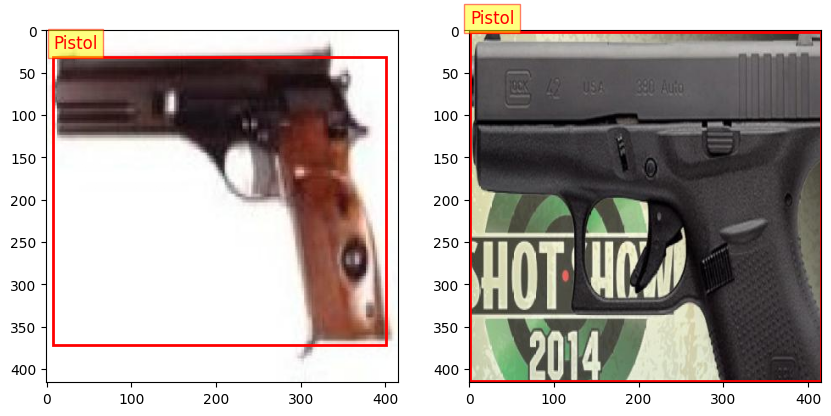

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.ravel()

# Get a batch of images and targets from the data loader
data_loader_iter = iter(train_data_loader)
images, targets = next(data_loader_iter)


class_names = ['bg', 'Pistol']

# Plot the images with bounding boxes
for idx in range(2):
    image = images[idx].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C) for visualization
    target = targets[idx]
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    ax[idx].imshow(image)

    # Add bounding boxes to the image
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin),
            width,
            height,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
        ax[idx].add_patch(rect)
        ax[idx].text(
            xmin,
            ymin - 10,
            f"{class_names[label]}",
            color="red",
            fontsize=12,
            bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="red"),
        )

# Display the image with bounding boxes
plt.show()

In [ ]:
# Step 6: Training Loop

train_loss = []
val_loss = []

for epoch in range(num_epochs):

    print(f'Starting the trainig of Epoch_{epoch+1}.....')
    print('Training...')

    model.train()
    train_running_loss = 0

    print(f'Epoch {epoch+1}/{num_epochs} training')


    for images, targets in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        # loss_classifier → Measures how well the model classifies objects into correct categories.
        # loss_box_reg → Evaluates how accurately the predicted bounding boxes match the ground truth.
        # loss_objectness → Checks how confident the model is in detecting objects versus background.
        # loss_rpn_box_reg →
        
        # Backward pass
        optimizer.zero_grad() ## converting gradient value to zero for per batch
        losses.backward() ## compute the gradient
        optimizer.step() ## update the weights

        train_running_loss += losses.item()

    scheduler.step()
    train_loss.append(train_running_loss)
    print(f"Train_Loss: {train_running_loss/len(train_dataset):.4f}")
    print('\n')

Starting the trainig of Epoch_1.....
Training...
Epoch 1/10 training
Train_Loss: 0.0511


Starting the trainig of Epoch_2.....
Training...
Epoch 2/10 training
Train_Loss: 0.0310


Starting the trainig of Epoch_3.....
Training...
Epoch 3/10 training
Train_Loss: 0.0254


Starting the trainig of Epoch_4.....
Training...
Epoch 4/10 training
Train_Loss: 0.0208


Starting the trainig of Epoch_5.....
Training...
Epoch 5/10 training
Train_Loss: 0.0202


Starting the trainig of Epoch_6.....
Training...
Epoch 6/10 training
Train_Loss: 0.0197


Starting the trainig of Epoch_7.....
Training...
Epoch 7/10 training
Train_Loss: 0.0192


Starting the trainig of Epoch_8.....
Training...
Epoch 8/10 training
Train_Loss: 0.0192


Starting the trainig of Epoch_9.....
Training...
Epoch 9/10 training
Train_Loss: 0.0191


Starting the trainig of Epoch_10.....
Training...
Epoch 10/10 training
Train_Loss: 0.0191




In [14]:
# Step 7: Save Trained Model
torch.save(model.state_dict(), "faster_rcnn_custom.pth")

<ipython-input-16-8d19630fe83a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("faster_rcnn_custom.pth"))


{'boxes': tensor([[1.0251e+02, 0.0000e+00, 6.0719e+02, 4.2157e+02],
        [1.4833e+02, 3.0668e-02, 4.6606e+02, 2.9236e+02],
        [3.9202e+02, 1.3924e+02, 6.0622e+02, 3.2819e+02],
        [3.4608e+02, 3.4729e+01, 6.0983e+02, 4.1187e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9836, 0.1962, 0.1593, 0.1353], device='cuda:0')}
{'boxes': tensor([[230.9690,  41.0551, 574.6436, 261.9453],
        [ 98.4183,  33.5685, 550.9881, 355.7132],
        [117.6172, 157.5990, 154.2518, 180.0898]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.5855, 0.5023], device='cuda:0')}
{'boxes': tensor([[167.1115,  22.4522, 585.7504, 308.4272],
        [374.3051,  28.9385, 586.3093, 317.5875],
        [194.1156,  25.6412, 470.2192, 238.2300]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.1786, 0.0755], device='cuda:0')}
{'boxes': tensor([[168.7324,  56.4713, 374.9386, 

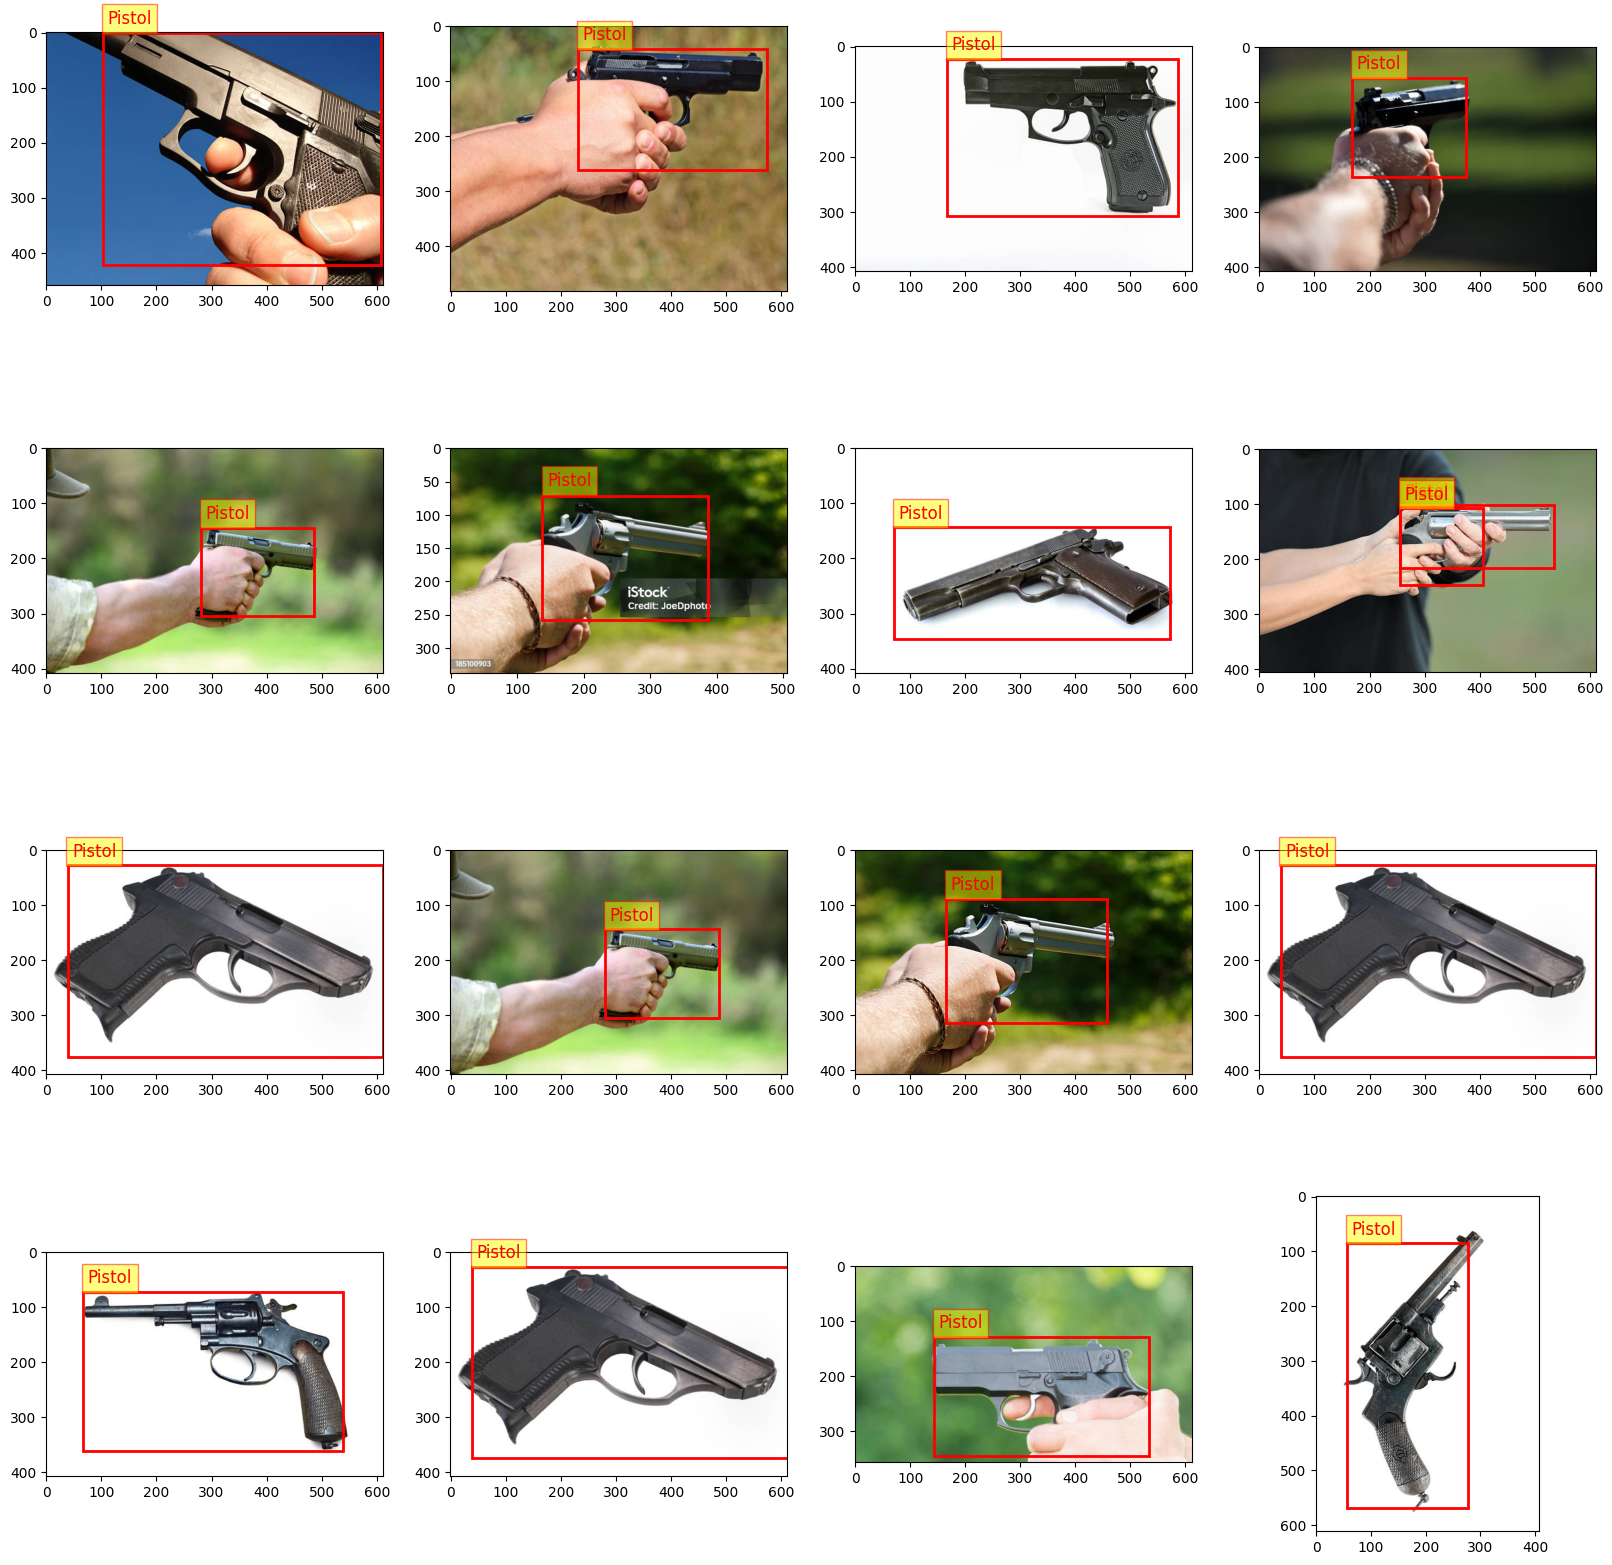

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image,ImageDraw
import random
import os
import torch
import torchvision
from torchvision.transforms import transforms


# Step 1: Recreate the model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Step 3: Load Pretrained Model and Modify for Custom Classes
num_classes = 2  # Number of classes (2 custom classes + 1 background)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# Replace the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


model.load_state_dict(torch.load("faster_rcnn_custom.pth"))
# Assuming `model` and `test_data_loader` are already defined
model.eval()  # Set the model to evaluation mode
model.to(device)  # Ensure the model is on the correct device

# Create the plot
fig, ax = plt.subplots(4, 4, figsize=(20,20))
ax = ax.ravel()

transform = transforms.ToTensor()

test_dir = "Pistols_Datasets/test/"
test_list_file = os.listdir(test_dir)
# font = ImageFont.truetype("arial.ttf", 28)


class_names = ['bg', 'Pistol']

for idx in range(16):
    # Prepare the image
    img_path = os.path.join(test_dir,random.choice(test_list_file))
    image = Image.open(img_path)
    image = transform(image)
    image_tensor = image.unsqueeze(0).to(device)  # Add a batch dimension

    # Get predictions
    with torch.no_grad():
        prediction = model(image_tensor)[0]  # Get the first image's predictions

    print(prediction)

    # Convert image to numpy for visualization
    image_np = image.cpu().permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)

    # Extract predictions
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    ax[idx].imshow(image_np)

    img = Image.open(img_path)
    colors = [(255,0,0),(0,255,0),(0,0,255),(255,0,255),(255,255,0),(0,255,255),(255,140,0),(0,128,0)]

    # Add bounding boxes to the image
    for box, label, score in zip(boxes, labels, scores):
        if score >= 0.8:
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle(
                (xmin, ymin),
                width,
                height,
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            ax[idx].add_patch(rect)
            ax[idx].text(
                xmin + 8,
                ymin - 16,
                f"{class_names[label]}",
                color="red",
                fontsize=12,
                bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="red"),
            )
            color = random.choice(colors)
            img1 = ImageDraw.Draw(img)
            img1.rectangle([(int(xmin),int(ymin)),(int(xmax),int(ymax))],outline=color,width=4)
            img1.text((int(xmin),int(ymin-30)), "Bear", fill=color)
            # img.save(f'img/image_{idx}.png')


# Display the image with bounding boxes
plt.show()